# Flight Delay Regression Analysis

In this notebook, we will perform a regression analysis on the flight delay dataset. The goal is to predict the exact arrival delay in minutes (`arr_delay`). We will explore several regression models, tune their hyperparameters, and evaluate their performance using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), and R-squared (R²).

The overall process will be:
1.  **Load and Prepare Data**: Load a 1 million sample subset of the dataset using our custom function.
2.  **Feature Engineering and Preprocessing**: Apply cyclical encoding for time-based features and target encoding for categorical variables.
3.  **Model Training and Evaluation**: Evaluate all models using 5-fold cross-validation:
    *   Linear Regression (baseline)
    *   Polynomial Regression
    *   Theil-Sen Regressor (on 100K subset due to computational cost)
    *   RANSAC Regressor
    *   Huber Regressor
4.  **Hyperparameter Tuning**: Tune all models using RandomizedSearchCV with 5-fold cross-validation.
5.  **Conclusion**: Compare all models and select the best performer.

## 1. Load and Prepare Data

Let's start by importing the necessary libraries and loading our dataset. We'll use the `load_regression_data` function, which is specifically designed to prepare the data for our regression task by selecting the correct features and target variable (`arr_delay`).

In [1]:
import numpy as np
import pandas as pd
import sys
import os

# Adjust the path to include the 'src' directory
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from regression.load_data import load_regression_data

# Load the data
X, y = load_regression_data()

# Drop rows with NaN in dep_time
print(f"\nData size before dropping NaNs: {len(X)}")
mask = X['dep_time'].notna()
X = X[mask]
y = y.loc[X.index]
print(f"Data size after dropping NaNs: {len(X)}")

# Use a subset of 1 million samples for the entire analysis
sample_size = 1_000_000
if len(X) > sample_size:
    print(f"Sampling down to {sample_size:,} rows for analysis.")
    X = X.sample(n=sample_size, random_state=42)
    y = y.loc[X.index]

# Display the shapes and first few rows to verify
print("\nShape of features (X):", X.shape)
print("Shape of target (y):", y.shape)
print("\nFirst 5 rows of features (X):")
print(X.head())
print("\nFirst 5 values of target (y):")
print(y.head())

Loading data from: /home/adam/university/sem5/machine_learning/Project/data/preprocessed_flight_data.csv
Data loaded successfully.

Data size before dropping NaNs: 6965266
Data loaded successfully.

Data size before dropping NaNs: 6965266
Data size after dropping NaNs: 6957682
Sampling down to 1,000,000 rows for analysis.
Data size after dropping NaNs: 6957682
Sampling down to 1,000,000 rows for analysis.

Shape of features (X): (1000000, 9)
Shape of target (y): (1000000,)

First 5 rows of features (X):
         month  day_of_month  day_of_week op_unique_carrier origin dest  \
6590746     12            12            4                AA    ORD  CLT   
4363239      8            18            7                OO    IDA  DFW   
1742151      4             7            7                AA    IND  CLT   
1246398      3            12            2                AA    CLT  PHL   
5651921     10            23            3                WN    ICT  PHX   

         dep_time  distance  dep_delay  

### Exploratory Data Analysis (EDA)

Before we proceed with feature engineering, let's perform some exploratory data analysis to understand the relationships within our data. We'll start with a correlation matrix and then visualize the relationship between each feature and the target variable, `arr_delay`.

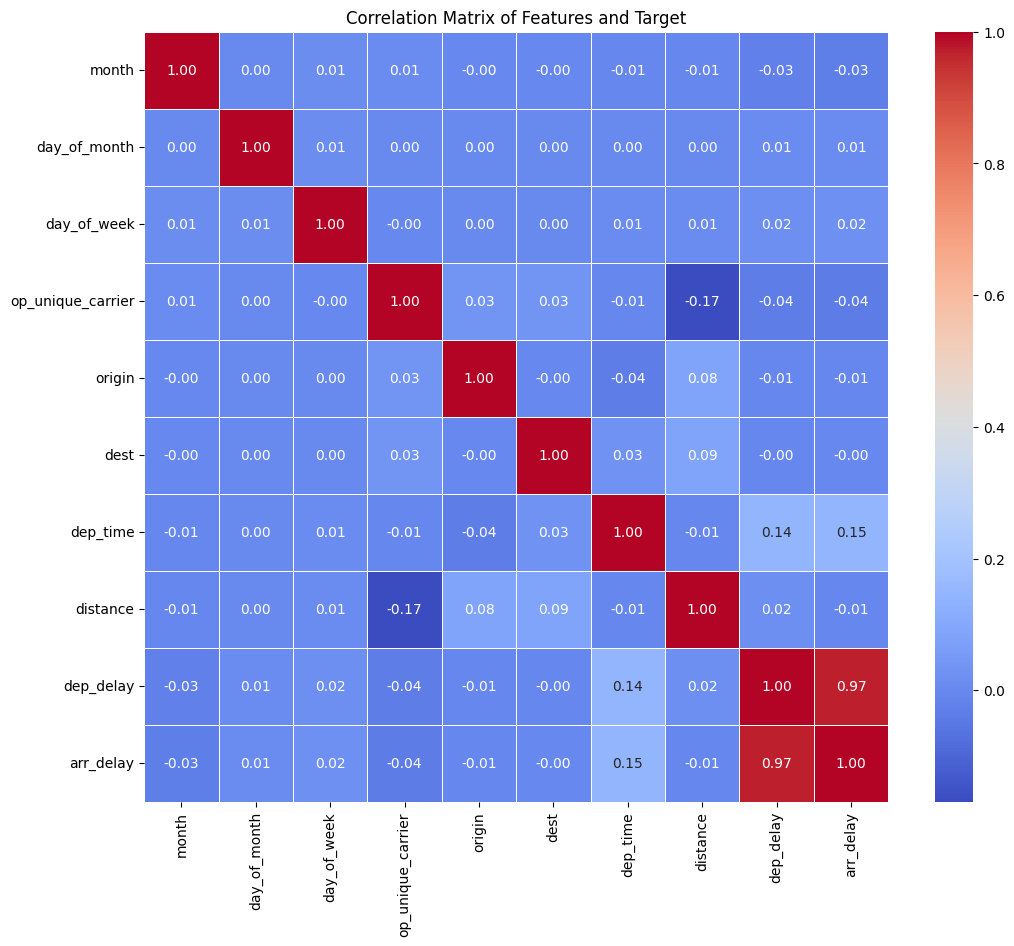

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine X and y for correlation analysis
data_for_corr = X.copy()
data_for_corr['arr_delay'] = y

# Convert categorical columns to numeric for correlation matrix
# This is a simplified approach for EDA; we'll use proper encoding for modeling
for col in data_for_corr.select_dtypes(include=['category', 'object']).columns:
    data_for_corr[col] = data_for_corr[col].astype('category').cat.codes

# Calculate the correlation matrix
correlation_matrix = data_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=.5)
plt.title('Correlation Matrix of Features and Target')
plt.show()

#### Scatter Plots of Features vs. Arrival Delay

Now let's visualize the relationship between each individual feature and the arrival delay. Since plotting millions of points can be slow and uninformative, we'll use a random sample of the data for these plots.

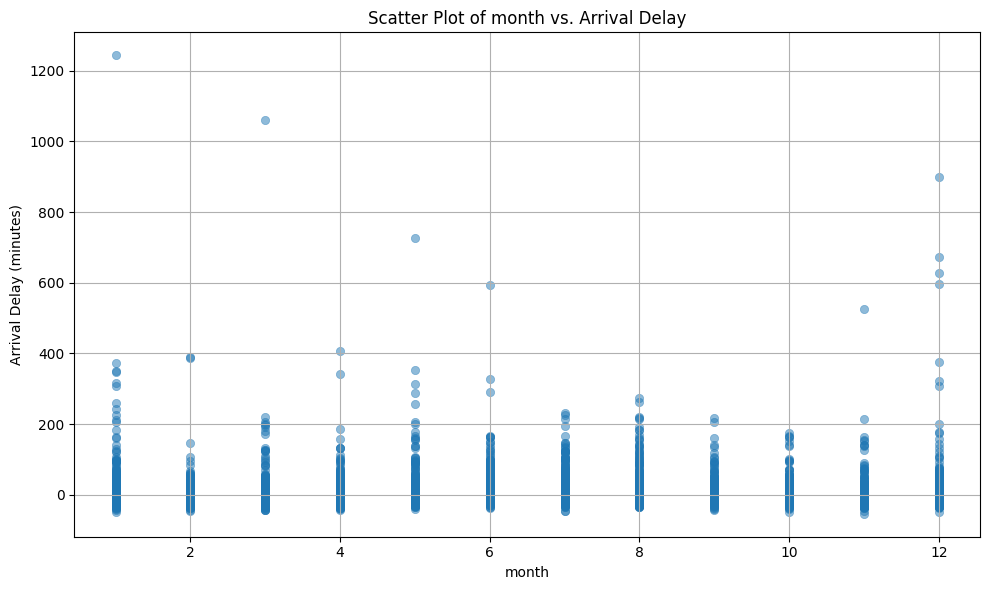

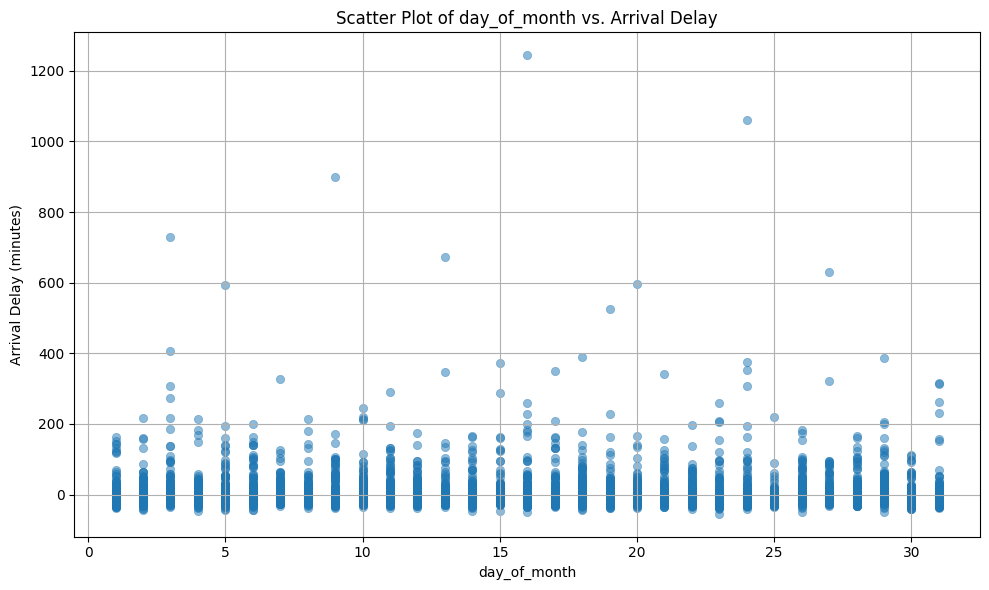

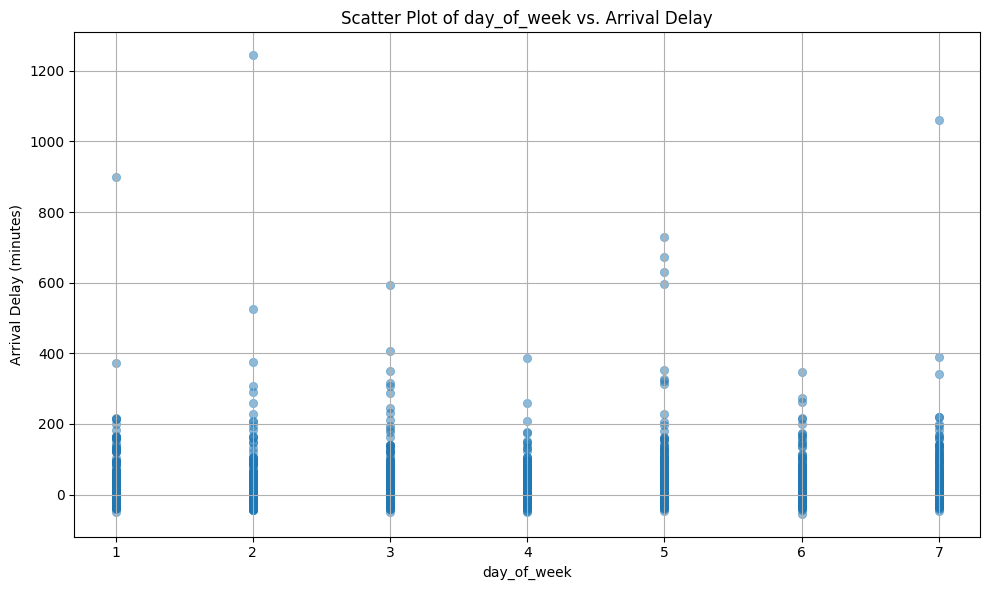

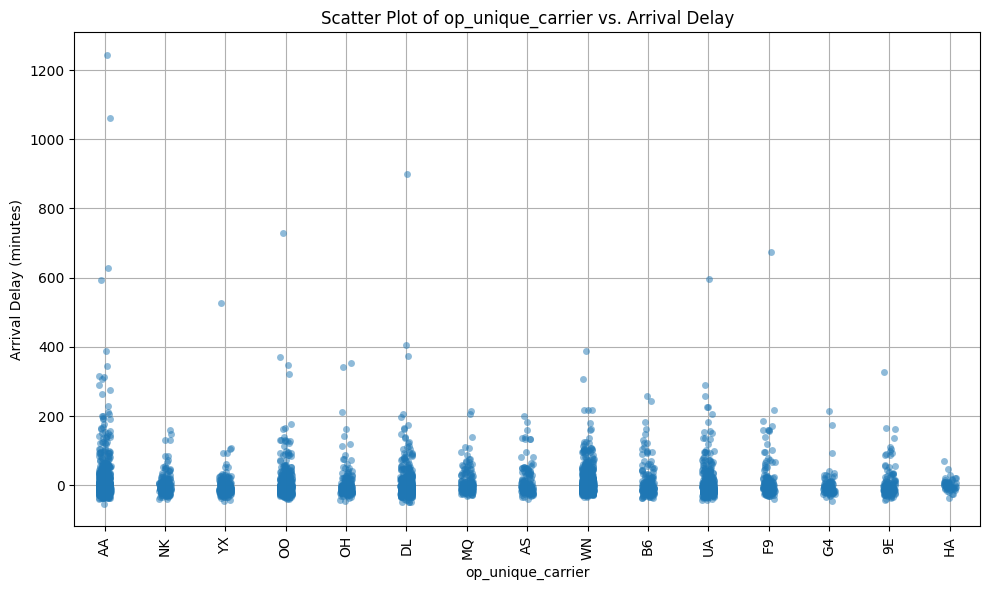

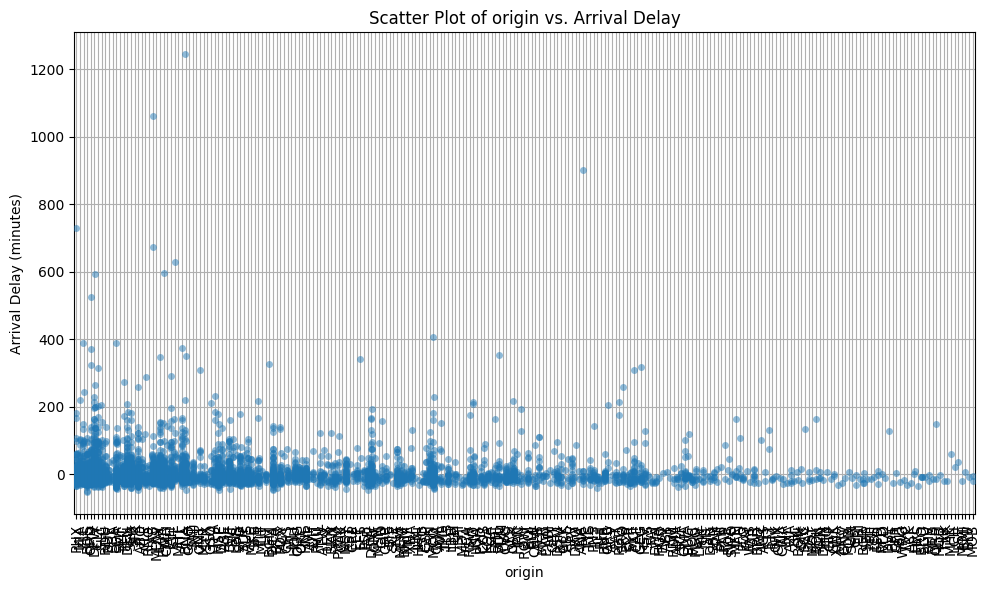

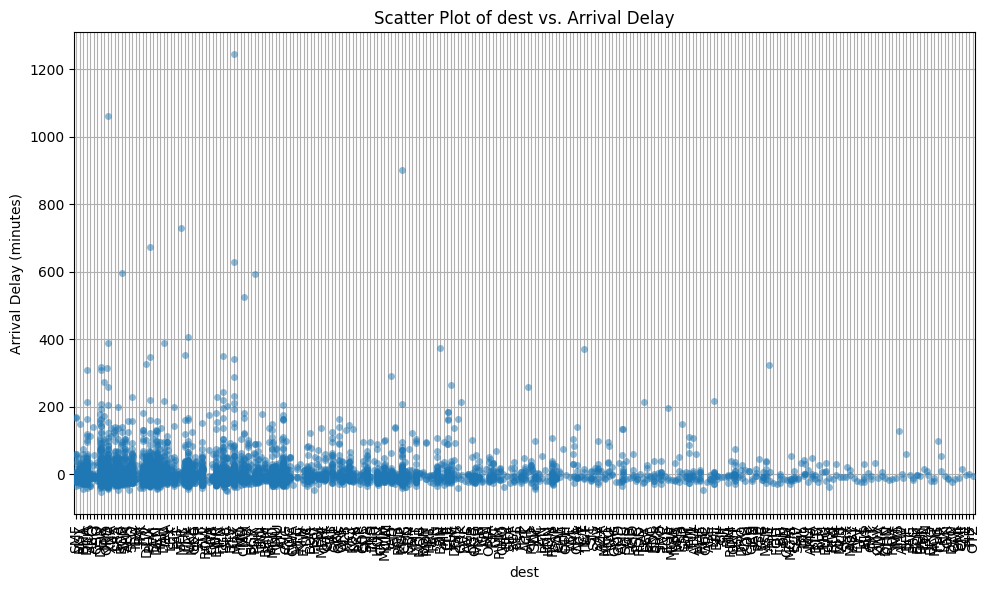

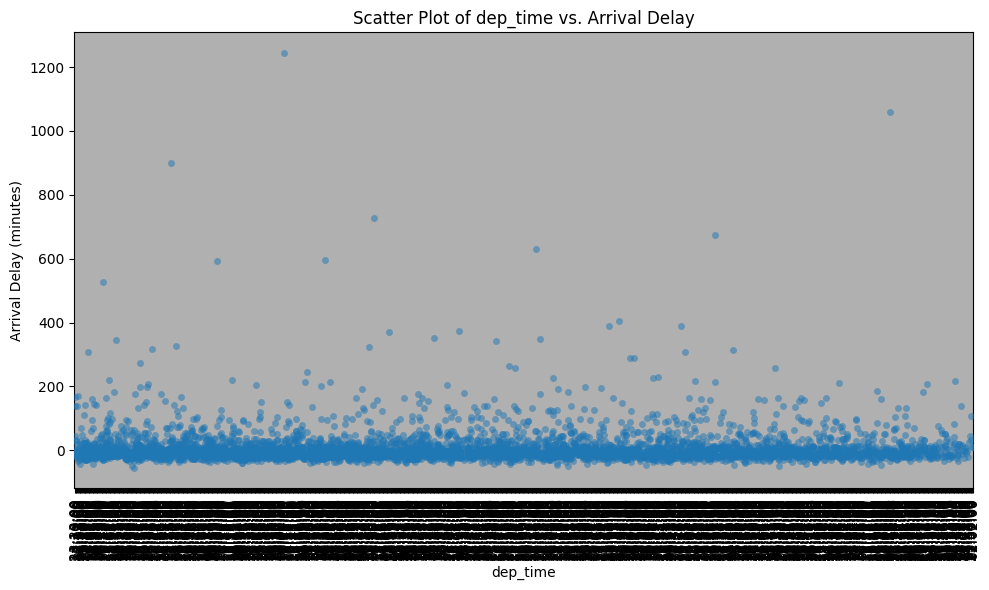

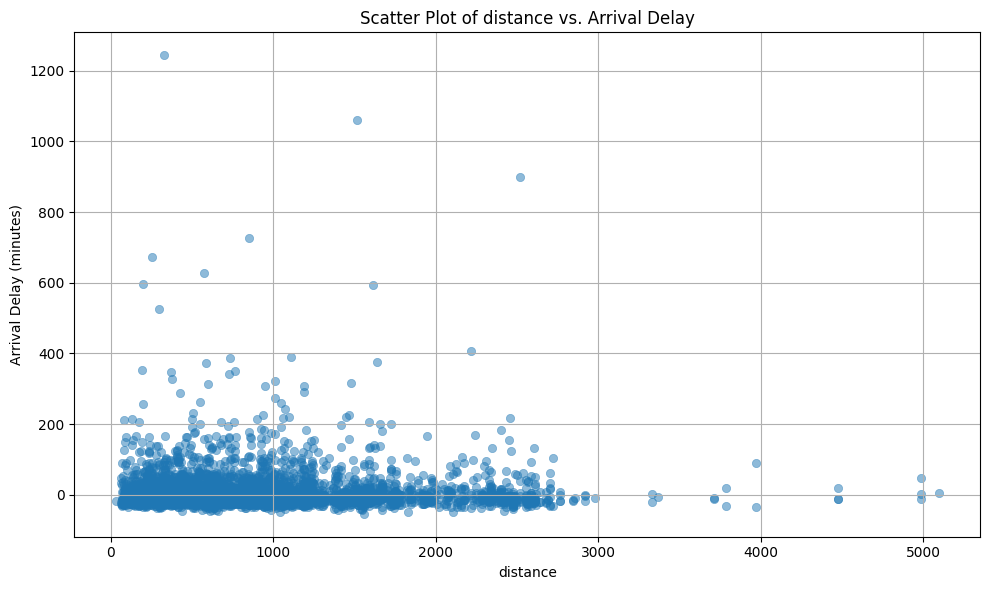

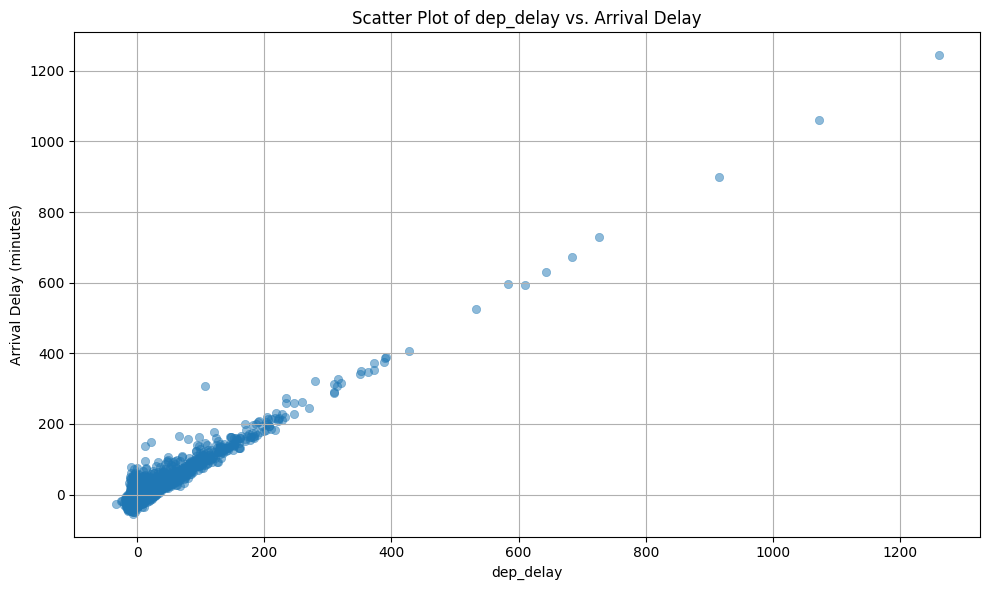

In [3]:
# Use a smaller sample for scatter plots to avoid overplotting and slow rendering
sample_size_scatter = 5000
if len(X) > sample_size_scatter:
    X_sample = X.sample(n=sample_size_scatter, random_state=42)
    y_sample = y.loc[X_sample.index]
else:
    X_sample = X
    y_sample = y

# Identify feature columns (excluding the target)
feature_cols = [col for col in X.columns]

# Create scatter plots for each feature against the target variable
for feature in feature_cols:
    plt.figure(figsize=(10, 6))

    # For categorical features, a scatter plot might not be the best,
    # but for a quick look, we can use it. A boxplot or violinplot would be better.
    if X[feature].dtype in ['category', 'object']:
        # Using stripplot for a better view of categorical data distribution
        sns.stripplot(x=X_sample[feature], y=y_sample, alpha=0.5, jitter=True)
        plt.xticks(rotation=90)
    else:
        # For numerical data, a scatter plot is appropriate
        sns.scatterplot(x=X_sample[feature], y=y_sample, alpha=0.5, edgecolor=None)

    plt.title(f'Scatter Plot of {feature} vs. Arrival Delay')
    plt.xlabel(feature)
    plt.ylabel('Arrival Delay (minutes)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 2. Feature Engineering and Preprocessing

Now, we'll construct a robust preprocessing pipeline. This pipeline will handle missing values, encode categorical variables, and scale numerical features. We will reuse the successful feature engineering techniques from our classification task, such as cyclical encoding for time-based features.

The steps are:
1.  **Cyclical Feature Transformation**: Convert `dep_time`, `month`, `day_of_week`, and `day_of_month` into sine and cosine components to preserve their cyclical nature.
2.  **Categorical Feature Encoding**: Apply target encoding to categorical columns like `op_unique_carrier`, `origin`, and `dest` (avoiding memory issues from one-hot encoding).
3.  **Numerical Feature Scaling**: Scale all numerical features to have a mean of 0 and a standard deviation of 1 using `StandardScaler`.
4.  **Imputation**: Fill any missing numerical values with the median.

This entire process will be encapsulated in a `ColumnTransformer` and a `Pipeline` to ensure consistency and prevent data leakage. The prepared data will be used for 5-fold cross-validation throughout the analysis.

In [4]:
import category_encoders as ce
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import numpy as np

# Helper function to convert HHMM time to minutes
def hhmm_to_minutes(time_val):
    if pd.isna(time_val):
        return np.nan
    try:
        s = str(int(float(time_val))).zfill(4)
        if s == '2400': return 0
        hour = int(s[:2])
        minute = int(s[2:])
        return hour * 60 + minute
    except (ValueError, TypeError):
        return np.nan

# Custom transformer for cyclical features
class CyclicalFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, variables_map):
        self.variables_map = variables_map
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        for var, max_val in self.variables_map.items():
            if var in X.columns:
                numeric_vals = pd.to_numeric(X[var], errors='coerce')
                X[f'{var}_sin'] = np.sin(2 * np.pi * numeric_vals / max_val)
                X[f'{var}_cos'] = np.cos(2 * np.pi * numeric_vals / max_val)
                X.drop(columns=[var], inplace=True)
        return X

# Custom transformer for time conversion
class TimeConverter(BaseEstimator, TransformerMixin):
    def __init__(self, variable):
        self.variable = variable
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X = X.copy()
        if self.variable in X.columns:
            X[self.variable] = X[self.variable].apply(hhmm_to_minutes)
        return X

# Define column groups
categorical_features = ['op_unique_carrier', 'origin', 'dest']
numerical_features = ['distance', 'dep_delay']

# Define the cyclical features that will be CREATED
cyclical_features_generated = [
    'dep_time_sin', 'dep_time_cos',
    'month_sin', 'month_cos',
    'day_of_week_sin', 'day_of_week_cos',
    'day_of_month_sin', 'day_of_month_cos'
]

# Combine all numerical features
all_numerical_features = numerical_features + cyclical_features_generated

# Create the preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('target_encoder', ce.TargetEncoder(handle_unknown='value', handle_missing='value'))
])

# Create the preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, all_numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)

# Create the final feature engineering pipeline
feature_pipeline = Pipeline(steps=[
    ('time_converter', TimeConverter(variable='dep_time')),
    ('cyclical_features', CyclicalFeatures(variables_map={
        'dep_time': 1440,
        'month': 12,
        'day_of_week': 7,
        'day_of_month': 31
    })),
    ('preprocessor', preprocessor)
])

# Fit and transform the entire dataset for cross-validation
X_prepared = feature_pipeline.fit_transform(X, y)

# Check for NaNs
nan_count = np.isnan(X_prepared).sum()
print(f"\nNaNs in X_prepared (after pipeline): {nan_count}")
if nan_count > 0:
    print("WARNING: NaNs are still present! Check your transformers.")

print("Shape of prepared data:", X_prepared.shape)

/home/adam/anaconda3/envs/flight-delay/lib/python3.13/site-packages/sklearn/impute/_base.py:653: UserWarning: Skipping features without any observed values: ['dep_time_sin' 'dep_time_cos']. At least one non-missing value is needed for imputation with strategy='median'.
  warnings.warn(



NaNs in X_prepared (after pipeline): 0
Shape of prepared data: (1000000, 11)


## 3. Model Training and Evaluation

With our data preprocessed, we can now train and evaluate our regression models using 5-fold cross-validation. We will store the evaluation metrics for each model in a dictionary to easily compare them at the end.

We'll define a helper function to compute the key regression metrics using cross-validation:
*   **Mean Absolute Error (MAE)**: Average absolute difference between predicted and actual values.
*   **Mean Squared Error (MSE)**: Average of the squares of the errors. More sensitive to large errors.
*   **Root Mean Squared Error (RMSE)**: The square root of MSE, putting the metric back into the original target's units.
*   **R-squared (R²)**: The proportion of the variance in the dependent variable that is predictable from the independent variable(s).

All metrics will be reported as mean ± standard deviation across the 5 folds.

### 3.1 Baseline Model: Linear Regression

We'll start with a simple Linear Regression model. This will serve as our baseline to determine if more complex models provide a significant improvement.

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
import time

# Dictionary to store model results
model_performance = {}

def evaluate_regressor_cv(name, model, X, y, cv=5, n_jobs=-1):
    """Evaluates a regression model using cross-validation and returns mean metrics."""
    print(f"--- Evaluating {name} with {cv}-fold cross-validation ---")

    # Define scorers
    scoring = {
        'neg_mae': 'neg_mean_absolute_error',
        'neg_mse': 'neg_mean_squared_error',
        'r2': 'r2'
    }

    start_time = time.time()
    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, n_jobs=n_jobs)
    end_time = time.time()

    # Extract and convert to positive values where needed
    mae = -cv_results['test_neg_mae'].mean()
    mae_std = cv_results['test_neg_mae'].std()
    mse = -cv_results['test_neg_mse'].mean()
    mse_std = cv_results['test_neg_mse'].std()
    rmse = np.sqrt(mse)
    r2 = cv_results['test_r2'].mean()
    r2_std = cv_results['test_r2'].std()

    print(f"Mean Absolute Error (MAE): {mae:.4f} (+/- {mae_std:.4f})")
    print(f"Mean Squared Error (MSE): {mse:.4f} (+/- {mse_std:.4f})")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R-squared (R²): {r2:.4f} (+/- {r2_std:.4f})")
    print(f"Total CV Time: {end_time - start_time:.4f} seconds\n")

    scores = {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2,
              'MAE_std': mae_std, 'MSE_std': mse_std, 'R2_std': r2_std}
    return scores

# --- Linear Regression ---
lin_reg = LinearRegression()

model_performance['Linear Regression'] = evaluate_regressor_cv(
    'Linear Regression', lin_reg, X_prepared, y, cv=5
)

--- Evaluating Linear Regression with 5-fold cross-validation ---


Mean Absolute Error (MAE): 9.6255 (+/- 0.0226)
Mean Squared Error (MSE): 191.5265 (+/- 0.7779)
Root Mean Squared Error (RMSE): 13.8393
R-squared (R²): 0.9414 (+/- 0.0014)
Total CV Time: 1.9589 seconds



### 3.2 Polynomial Regression

Next, we'll try Polynomial Regression. This model can capture non-linear relationships between features and the target by creating polynomial features (e.g., x², y², xy) and then fitting a linear model to this extended set of features. We'll use a degree of 2 to avoid excessive complexity and long training times.

In [6]:
from sklearn.preprocessing import PolynomialFeatures

# Create a pipeline for Polynomial Regression
poly_reg_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(degree=2, include_bias=False)),
    ("lin_reg", LinearRegression())
])

model_performance['Polynomial Regression (d=2)'] = evaluate_regressor_cv(
    'Polynomial Regression (d=2)', poly_reg_pipeline, X_prepared, y, cv=5
)

--- Evaluating Polynomial Regression (d=2) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.6104 (+/- 0.0215)
Mean Squared Error (MSE): 190.6955 (+/- 0.7636)
Root Mean Squared Error (RMSE): 13.8093
R-squared (R²): 0.9416 (+/- 0.0013)
Total CV Time: 12.4596 seconds

Mean Absolute Error (MAE): 9.6104 (+/- 0.0215)
Mean Squared Error (MSE): 190.6955 (+/- 0.7636)
Root Mean Squared Error (RMSE): 13.8093
R-squared (R²): 0.9416 (+/- 0.0013)
Total CV Time: 12.4596 seconds



### 3.3 Robust Regressors

Linear and Polynomial regression can be sensitive to outliers. Since flight delays can sometimes be extreme, it's wise to explore models that are inherently more robust to these outliers. We will test three such models: Theil-Sen, RANSAC, and Huber.

#### Theil-Sen Regressor

The Theil-Sen estimator calculates the median of the slopes of lines through all pairs of points, making it highly resistant to outliers.

In [7]:
from sklearn.linear_model import TheilSenRegressor

# Theil-Sen is computationally intensive, use a smaller subset
n_samples_theil = 100_000
X_theil = X_prepared[:n_samples_theil]
y_theil = y.iloc[:n_samples_theil]

print(f"Using {n_samples_theil:,} samples for Theil-Sen Regressor")

theil_sen_reg = TheilSenRegressor(random_state=42, n_jobs=-1)

# For Theil-Sen, we need to use a custom evaluation to avoid memory issues
# We'll use n_jobs=1 in cross_validate to prevent parallel workers from being killed
print(f"--- Evaluating Theil-Sen Regressor with 5-fold cross-validation ---")

from sklearn.model_selection import cross_validate

scoring = {
    'neg_mae': 'neg_mean_absolute_error',
    'neg_mse': 'neg_mean_squared_error',
    'r2': 'r2'
}

import time
start_time = time.time()
# Use n_jobs=1 to avoid memory issues with parallel processing
cv_results = cross_validate(theil_sen_reg, X_theil, y_theil, cv=5, scoring=scoring, n_jobs=1, verbose=2)
end_time = time.time()

# Extract and convert to positive values where needed
mae = -cv_results['test_neg_mae'].mean()
mae_std = cv_results['test_neg_mae'].std()
mse = -cv_results['test_neg_mse'].mean()
mse_std = cv_results['test_neg_mse'].std()
rmse = np.sqrt(mse)
r2 = cv_results['test_r2'].mean()
r2_std = cv_results['test_r2'].std()

print(f"Mean Absolute Error (MAE): {mae:.4f} (+/- {mae_std:.4f})")
print(f"Mean Squared Error (MSE): {mse:.4f} (+/- {mse_std:.4f})")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R-squared (R²): {r2:.4f} (+/- {r2_std:.4f})")
print(f"Total CV Time: {end_time - start_time:.4f} seconds\n")

model_performance['Theil-Sen Regressor'] = {
    'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2,
    'MAE_std': mae_std, 'MSE_std': mse_std, 'R2_std': r2_std
}

Using 100,000 samples for Theil-Sen Regressor
--- Evaluating Theil-Sen Regressor with 5-fold cross-validation ---
[CV] END .................................................... total time=  14.5s
[CV] END .................................................... total time=  14.5s
[CV] END .................................................... total time=  12.5s
[CV] END .................................................... total time=  12.5s
[CV] END .................................................... total time=  14.4s
[CV] END .................................................... total time=  14.4s
[CV] END .................................................... total time=  12.0s
[CV] END .................................................... total time=  12.0s
[CV] END .................................................... total time=  14.6s
Mean Absolute Error (MAE): 9.5184 (+/- 0.0852)
Mean Squared Error (MSE): 189.1566 (+/- 5.1645)
Root Mean Squared Error (RMSE): 13.7534
R-squared (R²): 0.9455

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.1min finished


#### RANSAC Regressor

RANSAC (RANdom SAmple Consensus) is an iterative method that fits a model to a subset of "inliers" from the data. It separates the data into inliers (which are explained by the model) and outliers, making it very effective in the presence of a large number of outliers.

In [8]:
from sklearn.linear_model import RANSACRegressor

ransac_reg = RANSACRegressor(random_state=42)

model_performance['RANSAC Regressor'] = evaluate_regressor_cv(
    'RANSAC Regressor', ransac_reg, X_prepared, y, cv=5
)

--- Evaluating RANSAC Regressor with 5-fold cross-validation ---
Mean Absolute Error (MAE): 11.9947 (+/- 1.0446)
Mean Squared Error (MSE): 300.4652 (+/- 64.6611)
Root Mean Squared Error (RMSE): 17.3339
R-squared (R²): 0.9082 (+/- 0.0190)
Total CV Time: 4.1917 seconds

Mean Absolute Error (MAE): 11.9947 (+/- 1.0446)
Mean Squared Error (MSE): 300.4652 (+/- 64.6611)
Root Mean Squared Error (RMSE): 17.3339
R-squared (R²): 0.9082 (+/- 0.0190)
Total CV Time: 4.1917 seconds



#### Huber Regressor

The Huber Regressor is a compromise between MAE and MSE. It uses a quadratic loss (like MSE) for small errors and a linear loss (like MAE) for large errors, which makes it less sensitive to outliers than a standard linear model using only MSE.

In [9]:
from sklearn.linear_model import HuberRegressor

huber_reg = HuberRegressor(max_iter=500)

model_performance['Huber Regressor'] = evaluate_regressor_cv(
    'Huber Regressor', huber_reg, X_prepared, y, cv=5
)

--- Evaluating Huber Regressor with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.5033 (+/- 0.0197)
Mean Squared Error (MSE): 193.7888 (+/- 0.7781)
Root Mean Squared Error (RMSE): 13.9208
R-squared (R²): 0.9407 (+/- 0.0014)
Total CV Time: 6.3864 seconds

Mean Absolute Error (MAE): 9.5033 (+/- 0.0197)
Mean Squared Error (MSE): 193.7888 (+/- 0.7781)
Root Mean Squared Error (RMSE): 13.9208
R-squared (R²): 0.9407 (+/- 0.0014)
Total CV Time: 6.3864 seconds



## 4. Hyperparameter Tuning for All Models

Now we'll perform hyperparameter tuning for each model using `RandomizedSearchCV` with 5-fold cross-validation. This will help us find the optimal hyperparameters for each regressor and potentially improve their performance.

### 4.1 Linear Regression with Regularization (Ridge and Lasso)

Standard Linear Regression has no hyperparameters to tune, but we can explore regularized variants like Ridge and Lasso regression.

In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge, Lasso
from scipy.stats import loguniform

# Ridge Regression tuning
param_dist_ridge = {
    'alpha': loguniform(1e-3, 1e3)
}

random_search_ridge = RandomizedSearchCV(
    Ridge(),
    param_distributions=param_dist_ridge,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Reduced from -1 to avoid memory issues
    random_state=42,
    verbose=1
)

print("Tuning Ridge Regression...")
random_search_ridge.fit(X_prepared, y)
print(f"Best parameters for Ridge: {random_search_ridge.best_params_}")

best_ridge_model = random_search_ridge.best_estimator_
model_performance['Ridge Regression (Tuned)'] = evaluate_regressor_cv(
    'Ridge Regression (Tuned)', best_ridge_model, X_prepared, y, cv=5
)

# Lasso Regression tuning
param_dist_lasso = {
    'alpha': loguniform(1e-3, 1e3)
}

random_search_lasso = RandomizedSearchCV(
    Lasso(max_iter=5000),
    param_distributions=param_dist_lasso,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Reduced from -1 to avoid memory issues
    random_state=42,
    verbose=1
)

print("\nTuning Lasso Regression...")
random_search_lasso.fit(X_prepared, y)
print(f"Best parameters for Lasso: {random_search_lasso.best_params_}")

best_lasso_model = random_search_lasso.best_estimator_
model_performance['Lasso Regression (Tuned)'] = evaluate_regressor_cv(
    'Lasso Regression (Tuned)', best_lasso_model, X_prepared, y, cv=5
)

Tuning Ridge Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Ridge: {'alpha': np.float64(1.9066091638188458)}
--- Evaluating Ridge Regression (Tuned) with 5-fold cross-validation ---
Best parameters for Ridge: {'alpha': np.float64(1.9066091638188458)}
--- Evaluating Ridge Regression (Tuned) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.6255 (+/- 0.0226)
Mean Squared Error (MSE): 191.5265 (+/- 0.7780)
Root Mean Squared Error (RMSE): 13.8393
R-squared (R²): 0.9414 (+/- 0.0014)
Total CV Time: 1.7143 seconds


Tuning Lasso Regression...
Mean Absolute Error (MAE): 9.6255 (+/- 0.0226)
Mean Squared Error (MSE): 191.5265 (+/- 0.7780)
Root Mean Squared Error (RMSE): 13.8393
R-squared (R²): 0.9414 (+/- 0.0014)
Total CV Time: 1.7143 seconds


Tuning Lasso Regression...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, 

### 4.2 Polynomial Regression Tuning

For Polynomial Regression, we'll tune the degree of the polynomial as well as add regularization (Ridge) to prevent overfitting.

In [11]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.stats import randint

# Use a smaller subset for polynomial tuning due to feature explosion
n_samples_poly = 200_000
X_poly = X_prepared[:n_samples_poly]
y_poly = y.iloc[:n_samples_poly]

print(f"Using {n_samples_poly:,} samples for Polynomial Regression tuning")

# Create a pipeline for tuning
poly_pipeline = Pipeline([
    ("poly_features", PolynomialFeatures(include_bias=False)),
    ("ridge", Ridge())
])

param_dist_poly = {
    'poly_features__degree': randint(2, 4),  # Test degrees 2-3
    'ridge__alpha': loguniform(1e-2, 1e3)
}

random_search_poly = RandomizedSearchCV(
    poly_pipeline,
    param_distributions=param_dist_poly,
    n_iter=20,  # Reduced iterations
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=2,  # Further reduced to avoid memory issues with polynomial features
    random_state=42,
    verbose=1
)

print("Tuning Polynomial Regression...")
random_search_poly.fit(X_poly, y_poly)
print(f"Best parameters for Polynomial Regression: {random_search_poly.best_params_}")

best_poly_model = random_search_poly.best_estimator_
# Evaluate on the smaller subset as well to match training
model_performance['Polynomial Regression (Tuned)'] = evaluate_regressor_cv(
    'Polynomial Regression (Tuned)', best_poly_model, X_poly, y_poly, cv=5
)

Using 200,000 samples for Polynomial Regression tuning
Tuning Polynomial Regression...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Polynomial Regression: {'poly_features__degree': 3, 'ridge__alpha': np.float64(0.013041036943413027)}
--- Evaluating Polynomial Regression (Tuned) with 5-fold cross-validation ---
Best parameters for Polynomial Regression: {'poly_features__degree': 3, 'ridge__alpha': np.float64(0.013041036943413027)}
--- Evaluating Polynomial Regression (Tuned) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.5740 (+/- 0.0604)
Mean Squared Error (MSE): 189.3019 (+/- 3.6279)
Root Mean Squared Error (RMSE): 13.7587
R-squared (R²): 0.9425 (+/- 0.0056)
Total CV Time: 3.6239 seconds

Mean Absolute Error (MAE): 9.5740 (+/- 0.0604)
Mean Squared Error (MSE): 189.3019 (+/- 3.6279)
Root Mean Squared Error (RMSE): 13.7587
R-squared (R²): 0.9425 (+/- 0.0056)
Total CV Time: 3

### 4.3 Theil-Sen Regressor Tuning

Theil-Sen has limited hyperparameters, but we can tune the `max_subpopulation` parameter which controls the number of samples used.

In [12]:
from sklearn.linear_model import TheilSenRegressor

# Use 100,000 samples for Theil-Sen tuning as it's computationally intensive
n_samples_theil = 100_000
X_theil = X_prepared[:n_samples_theil]
y_theil = y.iloc[:n_samples_theil]

print(f"Using {n_samples_theil:,} samples for Theil-Sen tuning")

param_dist_theil = {
    'max_subpopulation': randint(5000, 20000),
    'max_iter': randint(200, 500)
}

random_search_theil = RandomizedSearchCV(
    TheilSenRegressor(random_state=42, n_jobs=4),
    param_distributions=param_dist_theil,
    n_iter=20,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # Theil-Sen uses its own parallelization
    random_state=42,
    verbose=1
)

print("Tuning Theil-Sen Regressor...")
random_search_theil.fit(X_theil, y_theil)
print(f"Best parameters for Theil-Sen: {random_search_theil.best_params_}")

best_theil_model = random_search_theil.best_estimator_
# Use n_jobs=1 for Theil-Sen evaluation to avoid memory issues
model_performance['Theil-Sen Regressor (Tuned)'] = evaluate_regressor_cv(
    'Theil-Sen Regressor (Tuned)', best_theil_model, X_theil, y_theil, cv=5, n_jobs=1
)

Using 100,000 samples for Theil-Sen tuning
Tuning Theil-Sen Regressor...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for Theil-Sen: {'max_iter': 221, 'max_subpopulation': 11396}
--- Evaluating Theil-Sen Regressor (Tuned) with 5-fold cross-validation ---
Best parameters for Theil-Sen: {'max_iter': 221, 'max_subpopulation': 11396}
--- Evaluating Theil-Sen Regressor (Tuned) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.5190 (+/- 0.0867)
Mean Squared Error (MSE): 189.1322 (+/- 5.1127)
Root Mean Squared Error (RMSE): 13.7525
R-squared (R²): 0.9455 (+/- 0.0061)
Total CV Time: 75.1867 seconds

Mean Absolute Error (MAE): 9.5190 (+/- 0.0867)
Mean Squared Error (MSE): 189.1322 (+/- 5.1127)
Root Mean Squared Error (RMSE): 13.7525
R-squared (R²): 0.9455 (+/- 0.0061)
Total CV Time: 75.1867 seconds



### 4.4 RANSAC Regressor Tuning

RANSAC has several important hyperparameters including the minimum number of samples, residual threshold, and maximum iterations.

In [13]:
from sklearn.linear_model import RANSACRegressor
from scipy.stats import uniform

param_dist_ransac = {
    'min_samples': uniform(0.3, 0.4),  # 30-70% of data as minimum samples
    'residual_threshold': uniform(5.0, 20.0),  # Threshold for inliers
    'max_trials': randint(50, 200)
}

random_search_ransac = RandomizedSearchCV(
    RANSACRegressor(random_state=42),
    param_distributions=param_dist_ransac,
    n_iter=40,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Reduced from -1 to avoid memory issues
    random_state=42,
    verbose=1
)

print("Tuning RANSAC Regressor...")
random_search_ransac.fit(X_prepared, y)
print(f"Best parameters for RANSAC: {random_search_ransac.best_params_}")

best_ransac_model = random_search_ransac.best_estimator_
model_performance['RANSAC Regressor (Tuned)'] = evaluate_regressor_cv(
    'RANSAC Regressor (Tuned)', best_ransac_model, X_prepared, y, cv=5
)

Tuning RANSAC Regressor...
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best parameters for RANSAC: {'max_trials': 153, 'min_samples': np.float64(0.5832290311184182), 'residual_threshold': np.float64(5.411689885916049)}
--- Evaluating RANSAC Regressor (Tuned) with 5-fold cross-validation ---
Best parameters for RANSAC: {'max_trials': 153, 'min_samples': np.float64(0.5832290311184182), 'residual_threshold': np.float64(5.411689885916049)}
--- Evaluating RANSAC Regressor (Tuned) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.5716 (+/- 0.0224)
Mean Squared Error (MSE): 191.7275 (+/- 0.7772)
Root Mean Squared Error (RMSE): 13.8466
R-squared (R²): 0.9413 (+/- 0.0014)
Total CV Time: 44.4510 seconds

Mean Absolute Error (MAE): 9.5716 (+/- 0.0224)
Mean Squared Error (MSE): 191.7275 (+/- 0.7772)
Root Mean Squared Error (RMSE): 13.8466
R-squared (R²): 0.9413 (+/- 0.0014)
Total CV Time: 44.4510 seconds



### 4.5 Huber Regressor Tuning

The Huber Regressor has two key hyperparameters: `epsilon` (threshold for switching between quadratic and linear loss) and `alpha` (regularization strength).

In [14]:
from sklearn.linear_model import HuberRegressor

param_dist_huber = {
    'epsilon': uniform(1.0, 2.0),  # Typically between 1.0 and 2.0
    'alpha': loguniform(1e-5, 1e-1),
    'max_iter': randint(500, 2000)
}

random_search_huber = RandomizedSearchCV(
    HuberRegressor(),
    param_distributions=param_dist_huber,
    n_iter=50,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=4,  # Reduced from -1 to avoid memory issues
    random_state=42,
    verbose=1
)

print("Tuning Huber Regressor...")
random_search_huber.fit(X_prepared, y)
print(f"Best parameters for Huber: {random_search_huber.best_params_}")

best_huber_model = random_search_huber.best_estimator_
model_performance['Huber Regressor (Tuned)'] = evaluate_regressor_cv(
    'Huber Regressor (Tuned)', best_huber_model, X_prepared, y, cv=5
)

Tuning Huber Regressor...
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters for Huber: {'alpha': np.float64(0.0003401789991128539), 'epsilon': np.float64(2.9434241907782077), 'max_iter': 1142}
--- Evaluating Huber Regressor (Tuned) with 5-fold cross-validation ---
Best parameters for Huber: {'alpha': np.float64(0.0003401789991128539), 'epsilon': np.float64(2.9434241907782077), 'max_iter': 1142}
--- Evaluating Huber Regressor (Tuned) with 5-fold cross-validation ---
Mean Absolute Error (MAE): 9.5786 (+/- 0.0216)
Mean Squared Error (MSE): 191.6985 (+/- 0.7817)
Root Mean Squared Error (RMSE): 13.8455
R-squared (R²): 0.9413 (+/- 0.0014)
Total CV Time: 6.3649 seconds

Mean Absolute Error (MAE): 9.5786 (+/- 0.0216)
Mean Squared Error (MSE): 191.6985 (+/- 0.7817)
Root Mean Squared Error (RMSE): 13.8455
R-squared (R²): 0.9413 (+/- 0.0014)
Total CV Time: 6.3649 seconds



## 5. Final Model Comparison and Conclusion

Now let's consolidate all our results (both baseline and tuned models) into a single DataFrame and visualize the performance. This will allow us to clearly see which models performed best and how much hyperparameter tuning improved each model's performance.

--- Model Performance Comparison ---
                            Model        MAE         MSE       RMSE        R2  \
0               Linear Regression   9.625530  191.526463  13.839309  0.941392   
1     Polynomial Regression (d=2)   9.610407  190.695476  13.809253  0.941646   
2             Theil-Sen Regressor   9.518372  189.156619  13.753422  0.945518   
3                RANSAC Regressor  11.994675  300.465242  17.333933  0.908212   
4                 Huber Regressor   9.503340  193.788819  13.920805  0.940700   
5        Ridge Regression (Tuned)   9.625528  191.526463  13.839309  0.941392   
6        Lasso Regression (Tuned)   9.625421  191.526477  13.839309  0.941392   
7   Polynomial Regression (Tuned)   9.573984  189.301925  13.758704  0.942519   
8     Theil-Sen Regressor (Tuned)   9.519020  189.132213  13.752535  0.945525   
9        RANSAC Regressor (Tuned)   9.571557  191.727498  13.846570  0.941331   
10        Huber Regressor (Tuned)   9.578566  191.698472  13.845522  0.9

/tmp/ipykernel_2068/10108614.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='RMSE', y='Model', data=performance_df.sort_values('RMSE', ascending=False), ax=axes[0], palette='viridis')
/tmp/ipykernel_2068/10108614.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='R2', y='Model', data=performance_df.sort_values('R2', ascending=True), ax=axes[1], palette='plasma')


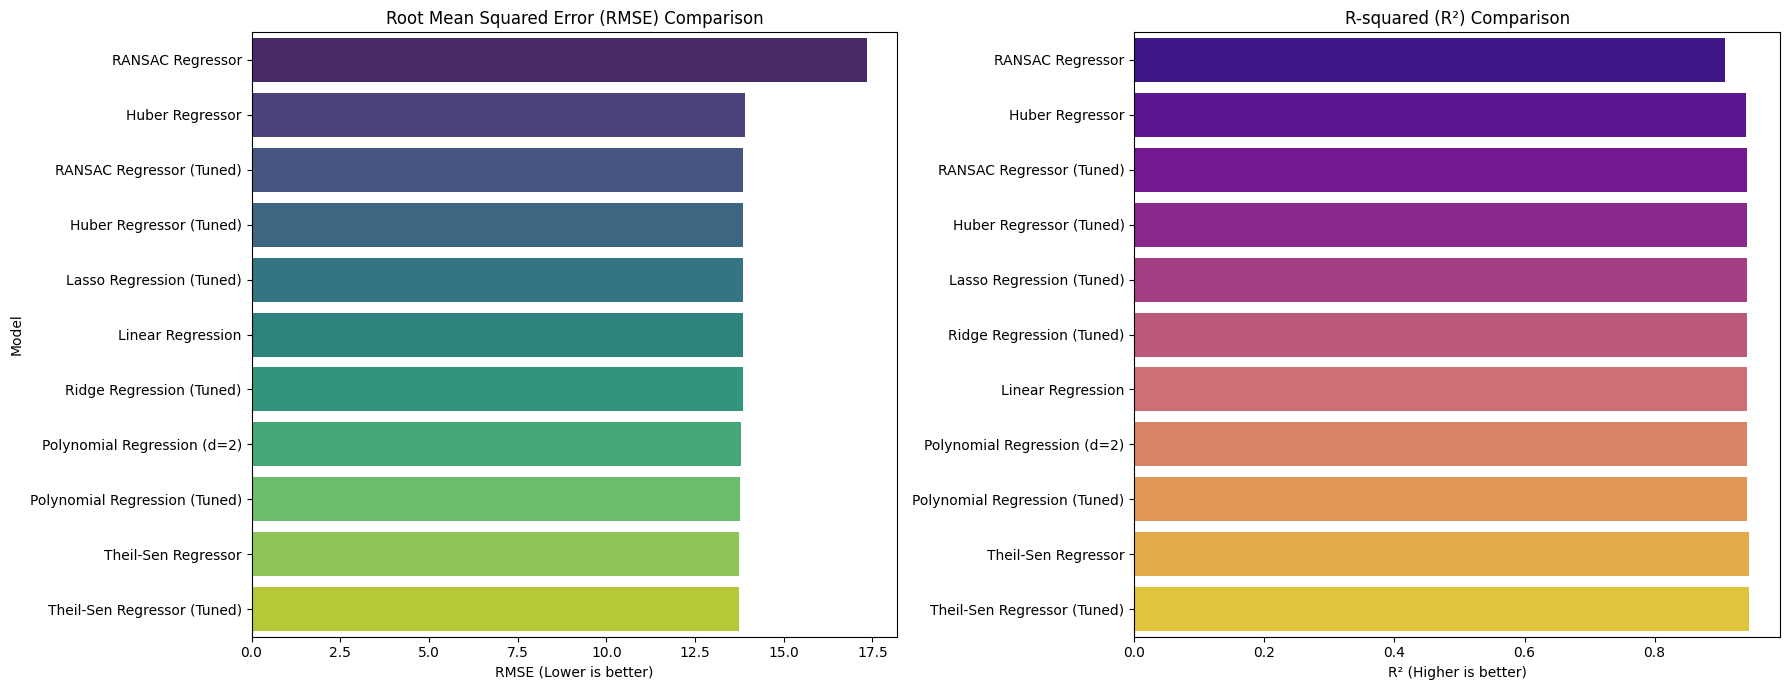

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Convert the performance dictionary to a DataFrame
performance_df = pd.DataFrame.from_dict(model_performance, orient='index')
performance_df.reset_index(inplace=True)
performance_df.rename(columns={'index': 'Model'}, inplace=True)

print("--- Model Performance Comparison ---")
print(performance_df)

# Plotting the results for better visualization
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot RMSE
sns.barplot(x='RMSE', y='Model', data=performance_df.sort_values('RMSE', ascending=False), ax=axes[0], palette='viridis')
axes[0].set_title('Root Mean Squared Error (RMSE) Comparison')
axes[0].set_xlabel('RMSE (Lower is better)')
axes[0].set_ylabel('Model')

# Plot R-squared
sns.barplot(x='R2', y='Model', data=performance_df.sort_values('R2', ascending=True), ax=axes[1], palette='plasma')
axes[1].set_title('R-squared (R²) Comparison')
axes[1].set_xlabel('R² (Higher is better)')
axes[1].set_ylabel('') # Hide y-axis label for clarity

plt.tight_layout()
plt.show()

# Flight Arrival Delay Regression Analysis

This notebook outlines a systematic approach to predict flight arrival delays in minutes. We will explore several regression models, from a simple linear baseline to more complex robust regressors, to handle the dataset's characteristics, such as its large size and the presence of outliers.

Our methodology is as follows:
1.  **Data Loading and Preprocessing**: We will load the data and apply feature engineering consistent with our previous classification tasks. This includes cyclical encoding for time-based features and one-hot encoding for categorical variables.
2.  **Model Training and Evaluation**: We will train and evaluate five different regression models: Linear Regression, Polynomial Regression, RANSAC, Theil-Sen, and Huber.
3.  **Hyperparameter Tuning**: For each model, we will use `RandomizedSearchCV` to find the best hyperparameters, training on a smaller subset of the data to manage computational load.
4.  **Final Comparison**: We will compare the performance of all models using a standard set of metrics to determine the most effective approach for this regression problem.